In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
import statsmodels.api as sm
import utils.DataSplitter
import utils.Sklearn
from utils.ColumnEnum import Columns
from utils.metrics import *

In [2]:
level = 60
line = '1A'
target = Columns.target_passengersBoarding

if level == 60:
    agg = 1
elif level == 30:
    agg = 2
elif level == 15:
    agg = 4

df_level = utils.DataSplitter.getTrainData(agglevel=level, diff=False)
df_level_line = df_level[df_level['line'] == line]
df_train, df_val = utils.DataSplitter.performTrainValSplit(df=df_level_line)

X_train = utils.DataSplitter.subsetColumns(df_train, dropCategorical=True, dropLags=True, dropWeather=False, dropCalendar=False, 
                                           dropSpecific=[target, Columns.calendar_Q1, Columns.calendar_mon]) # avoid multicolinearity
y_train = df_train[target]

X_val = utils.DataSplitter.subsetColumns(df_val, dropCategorical=True, dropLags=True, dropWeather=False, dropCalendar=False, 
                                         dropSpecific=[target, Columns.calendar_Q1, Columns.calendar_mon]) # avoid multicolinearity
y_val = df_val[target]

print(all(X_train.columns == X_val.columns))
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)
print(X_train.columns)

True
(14680, 27) (14680,) (1840, 27) (1840,)
Index(['peakHour', 'Q2', 'Q3', 'Q4', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun',
       'workdayPlan', 'saturdayPlan', 'sundayAndHolidayPlan', 'summerVacation',
       'fallVacation', 'christmasVacation', 'winterVacation', 'easterVacation',
       'acc_precip', 'bright_sunshine', 'mean_cloud_cover', 'mean_pressure',
       'mean_relative_hum', 'mean_temp', 'mean_wind_speed', 'snow_depth',
       'event'],
      dtype='object')


# Benchmark

## Seasonal naive with season 140 hours

Execution time: 0.003 sec


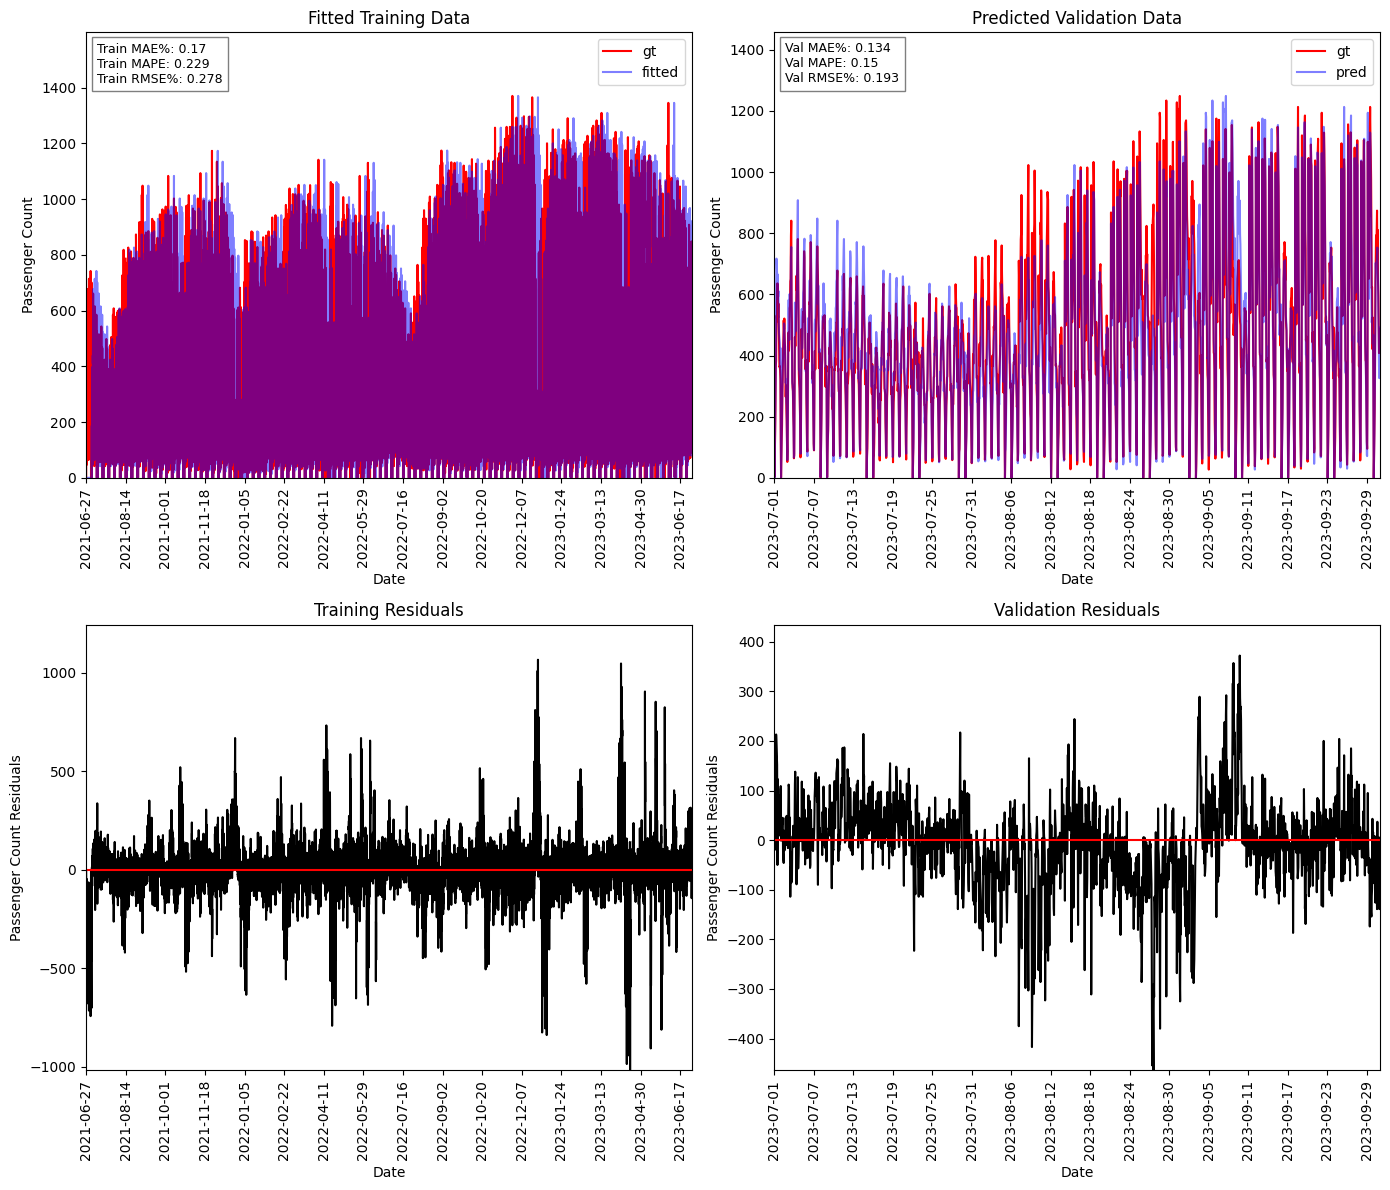

In [12]:
lookback = 140*agg # 140 * amount of observations per hour

timer = Time()
timer.start()
# same as past 140th observation
y_train_pred = y_train.shift(periods=lookback).fillna(0)
# concat train and val so lags are possible. Find same as past 140th observation.
y_val_pred = pd.concat([y_train, y_val]).shift(periods=lookback).fillna(0)[y_val.index]
print(timer.end())

# round and cut off train and val predictions
y_train_pred = y_train_pred.round()
y_train_pred[y_train_pred < 0] = 0
y_val_pred = y_val_pred.round()
y_val_pred[y_val_pred < 0] = 0


utils.tools.plotFitAndPredictions(y_train_pred=y_train_pred, y_val_pred=y_val_pred,
                                  y_train_true=y_train, y_val_true=y_val,
                                  dates=True, trainDateCol=df_train['date'], valDateCol=df_val['date'])

# Lasso

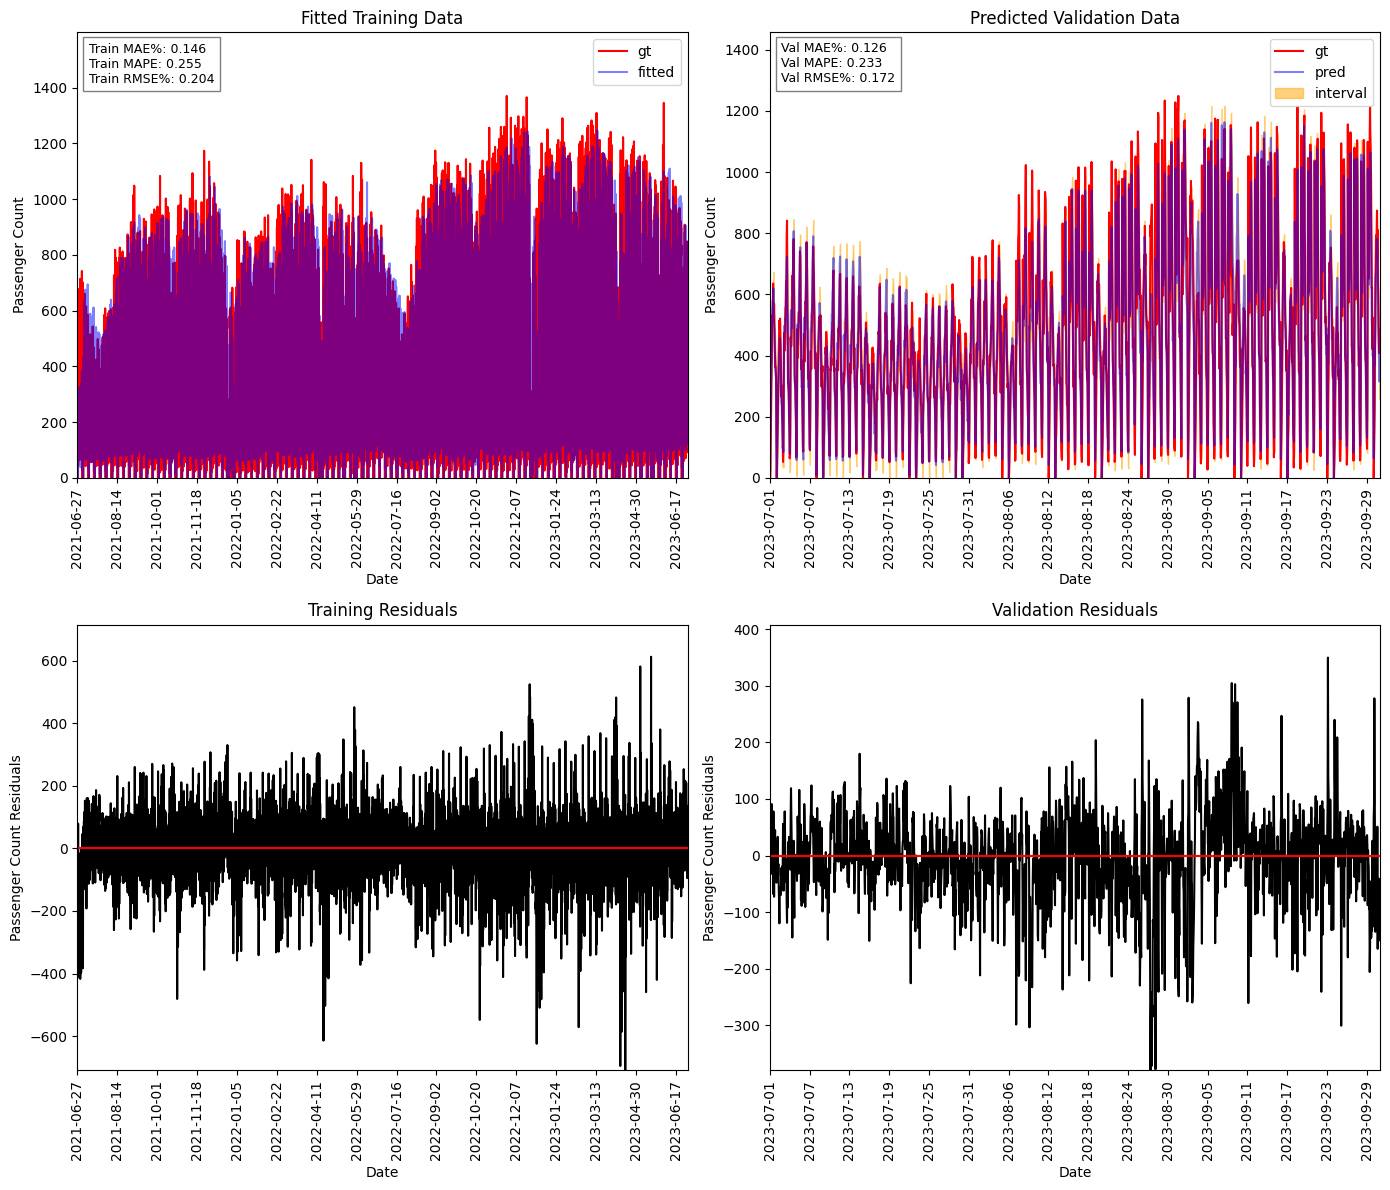

                            OLS Regression Results                            
Dep. Variable:     passengersBoarding   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     3482.
Date:                Thu, 04 Apr 2024   Prob (F-statistic):               0.00
Time:                        12:38:37   Log-Likelihood:                -87141.
No. Observations:               14680   AIC:                         1.743e+05
Df Residuals:                   14646   BIC:                         1.746e+05
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  200.5475 

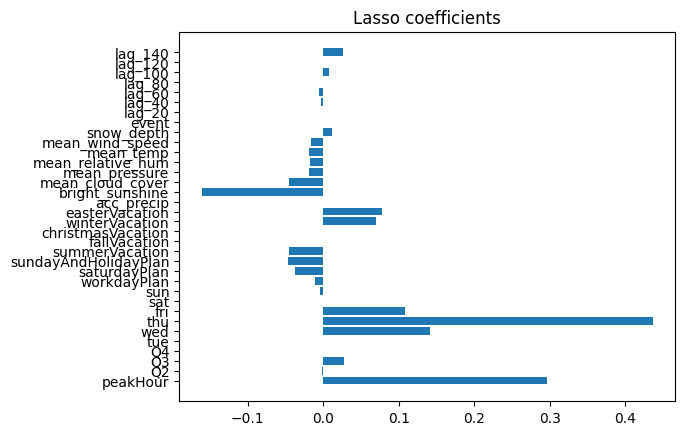

In [11]:
# fixed window 40 hours ahead
horizon = 40*agg

# best 60 min without diff
lags = [20, 40, 60, 80, 100, 120, 140]
differentiation = None
alpha = 0.005

# best 60 min with diff
#lags = [1, 20, 140]
#differentiation = 1
#alpha = 0.005

model = Lasso(alpha=alpha, fit_intercept=True, max_iter=1000)
scalar = StandardScaler()
exog_scalar = StandardScaler()

window_type = 'fixed'
window_size = None#X_train.shape[0]
use_exog = True
interval = [25, 75]

model, y_train_pred, y_val_pred = utils.Sklearn.sklearnForecast(
    differentiation=differentiation, lags=lags, window_type=window_type, window_size=window_size,
    interval=interval, horizon=horizon, 
    use_exog=use_exog, scalar=scalar, exog_scalar=exog_scalar,
    X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, model=model)

utils.tools.plotFitAndPredictions(y_train_pred=y_train_pred, y_val_pred=y_val_pred['pred'],
                                  y_train_true=y_train, y_val_true=y_val,
                                  y_val_lower= y_val_pred['lower_bound'], y_val_upper= y_val_pred['upper_bound'],
                                  dates=True, trainDateCol=df_train['date'], valDateCol=df_val['date'])

# Use statsmodels to perform OLS regression and output summary
X_train_lagged = X_train.copy(deep=True)
if lags:
    for lag in lags:
        X_train_lagged[f'lag_{lag}'] = y_train.shift(periods=lag).fillna(0)
ols_model = sm.OLS(y_train, sm.add_constant(X_train_lagged)).fit()
print(ols_model.summary())

plt.barh(X_train_lagged.columns, model.coef_)
plt.title('Lasso coefficients')
plt.show()

# Lasso grid search

In [9]:
horizon = 40*agg
window_list = ['fixed']
scalar = StandardScaler()
exog_scalar = StandardScaler()

for window_type in window_list:
    for useLags in [False, True]:
        for dropCalendar in [True, False]:
            for dropWeather in [True, False]:
                for diff in [1, None]:
                    if useLags == False and dropCalendar == True and dropWeather == True:
                        break

                    X_train = utils.DataSplitter.subsetColumns(df_train, dropCategorical=True, dropLags=True, 
                                                               dropWeather=dropWeather, dropCalendar=dropCalendar, 
                                                               dropSpecific=[target, Columns.calendar_Q1, Columns.calendar_mon]) # avoid multicolinearity

                    X_val = utils.DataSplitter.subsetColumns(df_val, dropCategorical=True, dropLags=True, 
                                                             dropWeather=dropWeather, dropCalendar=dropCalendar, 
                                                             dropSpecific=[target, Columns.calendar_Q1, Columns.calendar_mon]) # avoid multicolinearity

                    if useLags:
                        laglist = [[1], [2], [3], [4], [5], [6], [7], [8], [20], [40], [60], [80], [100], [120], [140],
                                    [1, 20, 140], [1, 4, 7, 8, 20],
                                    [1, 20, 40, 60, 80, 100, 120, 140],
                                    [1, 2, 3, 4, 5, 6, 7, 8], [20, 40, 60, 80, 100, 120, 140]]
                        laglist = [[i*agg for i in templist] for templist in laglist]
                    else:
                        laglist = [None]
                    
                    if window_type == 'rolling':
                        window_size = X_train.shape[0]
                    else:
                        window_size = None
                    
                    use_exog = True if dropCalendar == False or dropWeather == False else False

                    bestMAE = 1000000
                    # begin grid search
                    for alpha in [0.1, 0.05, 0.01, 0.005]:
                        for lags in laglist:
                            model = Lasso(alpha=alpha, fit_intercept=True, max_iter=1000)
                            model, y_train_pred, y_val_pred = utils.Sklearn.sklearnForecast(
                                    differentiation=diff, lags=lags, window_type=window_type, window_size=window_size,
                                    horizon=horizon, use_exog=use_exog, scalar=scalar, exog_scalar=exog_scalar,
                                    X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, model=model, interval=None)

                            trainMAE = nMAE(y=y_train, yhat=y_train_pred)
                            valMAE = nMAE(y=y_val, yhat=y_val_pred)
                            if valMAE < bestMAE:
                                bestMAE = valMAE
                                best_model = model
                                best_lags = lags
                                best_y_train_pred = y_train_pred
                                best_y_val_pred = y_val_pred
                    # end grid search
                    
                    trainMAE = nMAE(y=y_train, yhat=best_y_train_pred)
                    valMAE = nMAE(y=y_val, yhat=best_y_val_pred)
                    trainMAPE = MAPE(y=y_train, yhat=best_y_train_pred)
                    valMAPE = MAPE(y=y_val, yhat=best_y_val_pred)
                    trainRMSE = nRMSE(y=y_train, yhat=best_y_train_pred)
                    valRMSE = nRMSE(y=y_val, yhat=best_y_val_pred)
                    print('')
                    print(window_type, f'Lags:{useLags}', f'Drop cal:{dropCalendar}', f'drop Weather:{dropWeather}', f'Diff:{diff}')
                    print(model, f'Lags:{best_lags}')
                    print(trainMAE, trainMAPE, trainRMSE)
                    print(valMAE, valMAPE, valRMSE)


fixed Lags:False Drop cal:True drop Weather:False Diff:1
Lasso(alpha=0.005) Lags:None
0.69 1.009 0.881
0.66 1.155 0.847

fixed Lags:False Drop cal:True drop Weather:False Diff:None
Lasso(alpha=0.005) Lags:None
0.441 1.184 0.552
0.422 1.523 0.541

fixed Lags:False Drop cal:False drop Weather:True Diff:1
Lasso(alpha=0.005) Lags:None
0.597 0.855 0.772
0.601 1.106 0.782

fixed Lags:False Drop cal:False drop Weather:True Diff:None
Lasso(alpha=0.005) Lags:None
0.357 0.976 0.439
0.362 1.191 0.445

fixed Lags:False Drop cal:False drop Weather:False Diff:1
Lasso(alpha=0.005) Lags:None
0.603 0.974 0.775
0.587 1.263 0.77

fixed Lags:False Drop cal:False drop Weather:False Diff:None
Lasso(alpha=0.005) Lags:None
0.313 0.784 0.394
0.333 0.763 0.419

fixed Lags:True Drop cal:True drop Weather:True Diff:1
Lasso(alpha=0.005) Lags:[140]
0.226 0.347 0.324
0.187 0.273 0.252

fixed Lags:True Drop cal:True drop Weather:True Diff:None
Lasso(alpha=0.005) Lags:[20, 40, 60, 80, 100, 120, 140]
0.161 0.261 0.238

1A 60min:

Diff=None

$$
\begin{array}{c|c|c}
Model & \alpha & Lags\\
\hline
FLassoW   & 0.005 & None\\
\hline
FLassoC   & 0.005 & None\\
\hline
FLassoCW  & 0.005 & None\\
\hline
FLassoL   & 0.005 & [20, 40, 60, 80, 100, 120, 140]\\
\hline
FLassoLW  & 0.005 & [20, 40, 60, 80, 100, 120, 140]\\
\hline
FLassoLC  & 0.005 & [20, 40, 60, 80, 100, 120, 140]\\
\hline
FLassoLCW & 0.005 & [20, 40, 60, 80, 100, 120, 140]\\
\end{array}
$$


Diff=1

$$
\begin{array}{c|c|c}
Model & \alpha & Lags\\
\hline
FLassoW   & 0.005 & None\\
\hline
FLassoC   & 0.005 & None\\
\hline
FLassoCW  & 0.005 & None\\
\hline
FLassoL   & 0.005 & [140]\\
\hline
FLassoLW  & 0.005 & [140]\\
\hline
FLassoLC  & 0.005 & [140]\\
\hline
FLassoLCW & 0.005 & [1, 20, 140]\\
\end{array}
$$

# Skforecast implementation (always requires lags)

100%|██████████| 46/46 [01:08<00:00,  1.49s/it]


ValueError: x and y must have same first dimension, but have shapes (14680,) and (14540,)

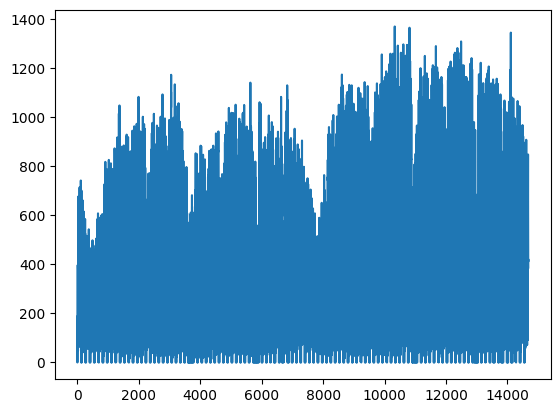

In [59]:
from skforecast.model_selection import backtesting_forecaster
from skforecast.ForecasterAutoreg import ForecasterAutoreg

forecaster = ForecasterAutoreg(
                 regressor = Lasso(alpha=0.01),
                 lags      = [20, 40, 60, 80, 100, 120, 140],
                 differentiation=None
             )

forecaster.fit(y=y_train, exog=X_train)

metric, y_train_pred = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = y_train,
                          exog                  = X_train,
                          steps                 = 1,
                          metric                = 'mean_squared_error',
                          initial_train_size    = None,
                          refit                 = False,
                          interval              = [5, 95],
                          verbose               = False,
                          show_progress         = True
                      )

metric, y_val_pred = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = pd.concat([y_train, y_val]),
                          exog                  = pd.concat([X_train, X_val]),
                          steps                 = 40,
                          metric                = 'mean_squared_error',
                          initial_train_size    = X_train.shape[0],
                          fixed_train_size      = False, # expanding window
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = True,
                          interval              = [5, 95],
                          verbose               = False,
                          show_progress         = True
                      )

plt.plot(y_train.index, y_train)
plt.plot(y_train_pred['pred'])
plt.show()

plt.plot(y_val.index, y_val)
plt.plot(y_val_pred['pred'])
plt.show()